# Predictive modelling of attrition data using Python SkLearn

In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# machine learning tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import time

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [2]:
# loading the dataset into a dataframe
attrition_df= pd.read_csv('attrition_df.csv')
print(attrition_df.shape)
print(attrition_df.columns)
print(attrition_df.dtypes)
attrition_df.sample(5)

(2000001, 12)
Index(['ee#', 'age', 'department', 'province', 'level', 'gender', 'ethnicity',
       'hire_source', 'promotion', 'tenure', 'previous_xp', 'total_xp'],
      dtype='object')
ee#              int64
age              int64
department      object
province        object
level           object
gender          object
ethnicity       object
hire_source     object
promotion       object
tenure         float64
previous_xp    float64
total_xp       float64
dtype: object


,ee#,age,department,province,level,gender,ethnicity,hire_source,promotion,tenure,previous_xp,total_xp
808787,10808787,51,IT,Quebec,Individual contributor,female,asian,referral,promoted,11.6,14.4,26.0
545309,10545309,41,IT,Ontario,Individual contributor,female,caucasian,direct,promoted,7.1,8.9,16.0
437180,10437180,34,IT,Nunavut,Individual contributor,male,pacific islander,referral,not_promoted,4.9,4.1,9.0
925196,10925196,40,HR,Prince Edward Island,Individual contributor,male,asian,referral,promoted,0.0,19.1,19.1
1709759,11709759,53,IT,Yukon Territory,Individual contributor,female,caucasian,direct,promoted,13.0,8.6,21.6


## Dataframe preparation

In [3]:
# creating a value to be predicted
# initializing target variable with ratio 60/40
np.random.seed(4)
num_samples= len(attrition_df)
status = np.random.choice(a= ['active', 'left'],
                          size= num_samples,
                          p= [0.6, 0.4])

# introducing subtle patterns in the data
for i in range(num_samples):
    if attrition_df['department'][i] == 'Project Management':
        status[i] = 'left' if np.random.rand() < 0.70 else status[i]
    if attrition_df['age'][i] > 50:
        status[i] = 'left' if np.random.rand() < 0.70 else status[i]
    if attrition_df['hire_source'][i] == 'direct':
        status[i] = 'left' if np.random.rand() < 0.70 else status[i]
    if attrition_df['province'][i] == 'Alberta':
        status[i] = 'left' if np.random.rand() < 0.70 else status[i]

attrition_df['status'] = status
attrition_df.sample(5)

,ee#,age,department,province,level,gender,ethnicity,hire_source,promotion,tenure,previous_xp,total_xp,status
1754641,11754641,50,HR,New Brunswick,Individual contributor,male,caucasian,referral,promoted,24.2,0.8,25.0,active
1829337,11829337,44,HR,Nunavut,Manager/Director,male,caucasian,direct,promoted,16.2,2.8,19.0,left
1469061,11469061,62,Customer Service,Saskatchewan,Individual contributor,female,middle eastern,direct,not_promoted,14.8,10.1,24.9,left
261592,10261592,26,Marketing,Nova Scotia,Individual contributor,male,caucasian,agency,not_promoted,0.0,12.5,12.5,left
1732592,11732592,62,Legal,Saskatchewan,Individual contributor,female,caucasian,direct,not_promoted,18.4,18.6,37.0,left


The target is initialized with a 60/40 ratio to provide both enough active and left cases to the model. 
The patterns introduced in the data are so that if any of the below conditions is met, the status 'left' is 60% likely to occur:
- Employees in 'Project Management'
- Employees above 50
- Employees hired directly
- Employees in Alberta

In [4]:
# breaking down the dataframe into individual predictors
attr_dummy_df= pd.get_dummies(data= attrition_df,
                             dtype= 'float64')
attr_dummy_df= attr_dummy_df.drop(columns=['status_left','promotion_not_promoted'],
                                  axis=1)
attr_dummy_df= attr_dummy_df.rename(columns={'promotion_promoted':'promotion',
                                             'status_active':'status'})
print(attr_dummy_df.columns)
attr_dummy_df.sample(5)

Index(['ee#', 'age', 'tenure', 'previous_xp', 'total_xp',
       'department_Customer Service', 'department_Finance', 'department_HR',
       'department_IT', 'department_Legal', 'department_Marketing',
       'department_Project Management', 'department_Sales', 'province_Alberta',
       'province_British Columbia', 'province_Manitoba',
       'province_New Brunswick', 'province_Newfoundland and Labrador',
       'province_Northwest Territories', 'province_Nova Scotia',
       'province_Nunavut', 'province_Ontario', 'province_Prince Edward Island',
       'province_Quebec', 'province_Saskatchewan', 'province_Yukon Territory',
       'level_Individual contributor', 'level_Manager/Director',
       'level_Senior Leadership', 'gender_female', 'gender_male',
       'gender_non-binary', 'ethnicity_african descent', 'ethnicity_asian',
       'ethnicity_bi-racial', 'ethnicity_caucasian', 'ethnicity_hispanic',
       'ethnicity_indigenous', 'ethnicity_middle eastern',
       'ethnicity_pacifi

,ee#,age,tenure,previous_xp,total_xp,department_Customer Service,department_Finance,department_HR,department_IT,department_Legal,...,ethnicity_caucasian,ethnicity_hispanic,ethnicity_indigenous,ethnicity_middle eastern,ethnicity_pacific islander,hire_source_agency,hire_source_direct,hire_source_referral,promotion,status
1532238,11532238,50,3.4,20.7,24.1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1522211,11522211,63,8.5,19.8,28.3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1351758,11351758,31,2.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1979893,11979893,36,0.0,13.8,13.8,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1172226,11172226,66,10.0,23.6,33.6,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
# OPTIONAL: simplifying down the df to our patterns for better readability
# two columns per predictor
attr_dummy_df= attr_dummy_df.drop(columns=[
       'department_Customer Service', 'department_Finance', 'department_HR',
       'department_IT', 'department_Legal', 'department_Sales', 'province_Manitoba',
       'province_New Brunswick', 'province_Newfoundland and Labrador',
       'province_Northwest Territories', 'province_Nova Scotia',
       'province_Nunavut', 'province_Ontario', 'province_Prince Edward Island',
       'province_Quebec', 'province_Saskatchewan', 'province_Yukon Territory', 
       'level_Individual contributor', 'level_Manager/Director', 
       'level_Senior Leadership', 'gender_female', 'gender_male',
       'gender_non-binary', 'ethnicity_african descent', 'ethnicity_asian',
       'ethnicity_bi-racial', 'ethnicity_caucasian', 'ethnicity_hispanic',
       'ethnicity_indigenous', 'ethnicity_middle eastern',
       'ethnicity_pacific islander', 'hire_source_agency'],
                                  axis=1)

attr_dummy_df.sample(5)

,ee#,age,tenure,previous_xp,total_xp,department_Marketing,department_Project Management,province_Alberta,province_British Columbia,hire_source_direct,hire_source_referral,promotion,status
1239134,11239134,66,18.9,11.8,30.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1531876,11531876,28,4.5,0.0,4.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
808976,10808976,60,21.9,4.5,26.4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1455516,11455516,36,3.9,7.1,11.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1534150,11534150,67,17.6,12.0,29.6,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


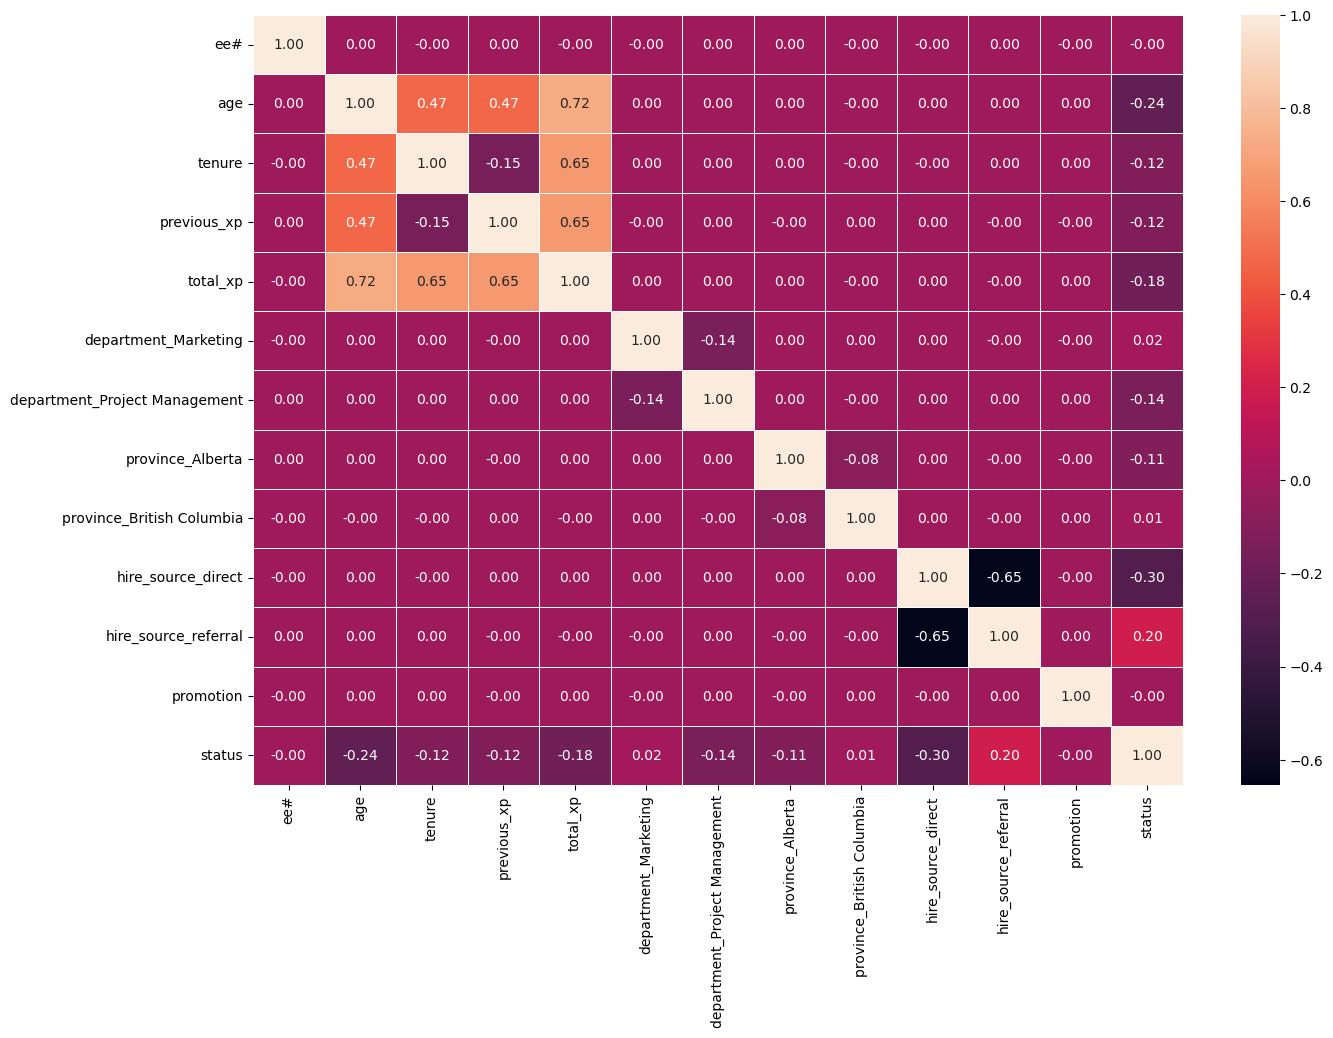

In [6]:
# correlation matrix
attr_corr_matrix= attr_dummy_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(attr_corr_matrix, 
            annot= True,
            linewidths= 0.5,
            fmt= ".2f")
plt.show()

## Data splitting and model initializations

In [7]:
# separating target variables from features with patterns
X_dept= pd.DataFrame(attr_dummy_df['department_Project Management'])
X_age= pd.DataFrame(attr_dummy_df['age'])
X_source= pd.DataFrame(attr_dummy_df['hire_source_direct'])
X_province= pd.DataFrame(attr_dummy_df['province_Alberta'])

y= attr_dummy_df['status']

In [8]:
# demonstrating train/test splits
# splitting department predictor into train vs test data
X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3)

# splitting age predictor into train vs test data
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3)

# splitting province predictor into train vs test data
X_train_province, X_test_province, y_train_province, y_test_province = train_test_split(X_province, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3)

Breaking down the hire source predictor we are focusing on for now into train, validation and test sets. 
To do this, we will use `train_test_split` twice
1. 80% train + validation / 20% test
2. 70% train / 30% validation

Final proportions will be:
- Test 20%
- Validation 24%
- Training 56%

In [9]:
# splitting source predictor into train + validation vs test data
X_remainder_source, X_test_source, y_remainder_source, y_test_source = \
        train_test_split(X_source, y, train_size= 0.8, test_size= 0.2)

# splitting source predictor into train vs validation data
X_train_source, X_validation_source, y_train_source, y_validation_source = \
        train_test_split(X_remainder_source, y_remainder_source,
                         train_size= 0.7, test_size= 0.3)

In [10]:
# checking size of each sets
print(f'Shape of test set: {X_test_source.shape[0]} items, or {(X_test_source.shape[0] / X_source.shape[0]*100):0.2f}% of the data.')
print(f'Shape of validation set: {X_validation_source.shape[0]} items, or {(X_validation_source.shape[0] / X_source.shape[0]*100):0.2f}% of the data.')
print(f'Shape of train set: {X_train_source.shape[0]} items, or {(X_train_source.shape[0] / X_source.shape[0]*100):0.2f}% of the data.')

Shape of test set: 400001 items, or 20.00% of the data.
Shape of validation set: 480000 items, or 24.00% of the data.
Shape of train set: 1120000 items, or 56.00% of the data.


## Cross validation of the Logistic Regression model

In [11]:
# Initialize-Fit-Score
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                    1,10,100,1000,10000,100000,1000000,10000000,\
                    100000000,1000000000])
lr_training_scores = []
lr_validation_scores = []
LR_evaluation = []

# evaluating different Cs on the model & timing execution
overall_start_time = time.time()

for c in C_range:
    iteration_info = {}
    local_start_time = time.time()
    
    # fitting the model
    cross_logreg = LogisticRegression(C= c)
    cross_logreg.fit(X_train_source, y_train_source)

    # training & scoring on validation
    train_score = cross_logreg.score(X_train_source,
                                     y_train_source)
    validation_score = cross_logreg.score(X_validation_source,
                                          y_validation_source)
    local_end_time = time.time()
    lr_training_scores.append(train_score)
    lr_validation_scores.append(validation_score)
    iteration_info['Parameter'] = f"Regularization {c:.2e}"
    iteration_info['Speed'] = local_end_time - local_start_time
    iteration_info['Training'] = f"{train_score *100:.2f}%"
    iteration_info['Validation'] = f"{validation_score *100:.2f}%"
    LR_evaluation.append(iteration_info)

overall_end_time = time.time()

print(f"Full testing of the Logistic Regression took {overall_end_time - overall_start_time:.6f} seconds")
LR_evaluation = pd.DataFrame(LR_evaluation)
LR_evaluation

Full testing of the Logistic Regression took 5.482725 seconds


,Parameter,Speed,Training,Validation
0,Regularization 1.00e-08,0.361593,76.63%,76.43%
1,Regularization 1.00e-07,0.324183,76.63%,76.43%
2,Regularization 1.00e-06,0.308245,76.63%,76.43%
3,Regularization 1.00e-05,0.296487,76.63%,76.43%
4,Regularization 1.00e-04,0.311131,76.63%,76.43%
5,Regularization 1.00e-03,0.326071,76.63%,76.43%
6,Regularization 1.00e-01,0.320736,76.63%,76.43%
7,Regularization 1.00e+00,0.320088,76.63%,76.43%
8,Regularization 1.00e+01,0.320769,76.63%,76.43%
9,Regularization 1.00e+02,0.320780,76.63%,76.43%


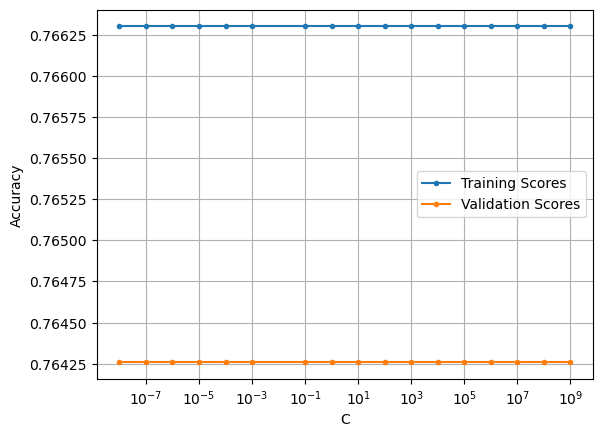

In [12]:
# plotting the training and validation scores for visualization
plt.figure()
plt.plot(C_range, lr_training_scores,
         label="Training Scores", marker='.')
plt.plot(C_range, lr_validation_scores,
         label="Validation Scores", marker='.')
plt.xscale('log')
plt.grid()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [13]:
# isolating the fastest 3 parameters
LR_evaluation.nsmallest(n= 3, columns= 'Speed')

,Parameter,Speed,Training,Validation
3,Regularization 1.00e-05,0.296487,76.63%,76.43%
2,Regularization 1.00e-06,0.308245,76.63%,76.43%
4,Regularization 1.00e-04,0.311131,76.63%,76.43%


## Cross validation of the Decision Tree model

In [14]:
# Initialize-Fit-Score
DT_depth = range(5, 50, 5)
DT_train_scores = []
DT_vali_scores = []
DT_evaluation = []

overall_start_time = time.time()
for d in DT_depth:
    iteration_info = {}
    local_start_time = time.time()
    cross_DT = DecisionTreeClassifier(max_depth= d)
    cross_DT.fit(X_train_source, y_train_source)
    
    # training & scoring on validation
    train_score = cross_DT.score(X_train_source,
                                 y_train_source)
    
    validation_score = cross_DT.score(X_validation_source,
                                      y_validation_source)
    local_end_time = time.time()
    DT_train_scores.append(train_score)
    DT_vali_scores.append(validation_score)
    iteration_info['Parameter'] = f"Max depth {d}"
    iteration_info['Speed'] = local_end_time - local_start_time
    iteration_info['Training'] = f"{train_score *100:.2f}%"
    iteration_info['Validation'] = f"{validation_score *100:.2f}%"
    DT_evaluation.append(iteration_info)

overall_end_time = time.time()
print(f"Full testing of the Decision Tree took {overall_end_time - overall_start_time:.6f} seconds")
DT_evaluation = pd.DataFrame(DT_evaluation)
DT_evaluation

Full testing of the Decision Tree took 2.178381 seconds


,Parameter,Speed,Training,Validation
0,Max depth 5,0.251305,76.63%,76.43%
1,Max depth 10,0.240548,76.63%,76.43%
2,Max depth 15,0.239329,76.63%,76.43%
3,Max depth 20,0.241143,76.63%,76.43%
4,Max depth 25,0.242682,76.63%,76.43%
5,Max depth 30,0.242171,76.63%,76.43%
6,Max depth 35,0.238609,76.63%,76.43%
7,Max depth 40,0.241792,76.63%,76.43%
8,Max depth 45,0.240606,76.63%,76.43%


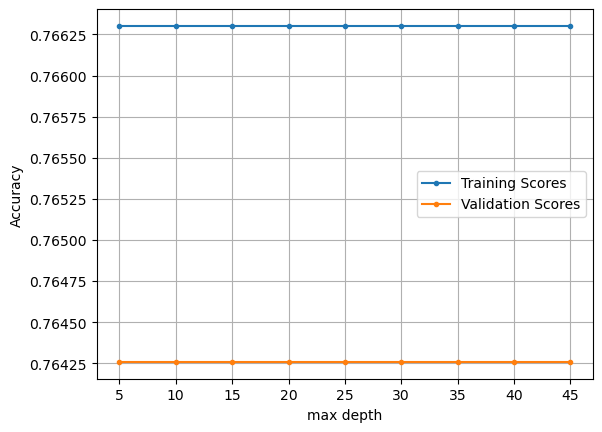

In [15]:
# plotting the training and validation scores for visualization
plt.figure()
plt.plot(DT_depth, DT_train_scores,
         label="Training Scores", marker='.')
plt.plot(DT_depth, DT_vali_scores,
         label="Validation Scores", marker='.')
plt.grid()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [16]:
# isolating the fastest 3 parameters
DT_evaluation.nsmallest(n= 3, columns= 'Speed')

,Parameter,Speed,Training,Validation
6,Max depth 35,0.238609,76.63%,76.43%
2,Max depth 15,0.239329,76.63%,76.43%
1,Max depth 10,0.240548,76.63%,76.43%
